#### Load package(s)

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import alphashape
import time
from descartes import PolygonPatch
from shapely import geometry
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import googlemaps
from config_googlemapsapi import key

gmaps = googlemaps.Client(key=key)

%matplotlib inline

ox.__version__

'1.1.2'

#### Load shapefile of grocery stores

In [8]:
stores = gpd.read_file('../Data/Grocery_Stores_20220224.shp', encoding='ISO-8859-1', index_col=True)
w, s, e, n = stores.total_bounds
stores = stores.to_crs(2274)

#### Retrieve bounding box and convert into a GeoDataFrame

(2413137.2544185035, 488267.03856800497, 2729035.7533323313, 714906.1186991709)

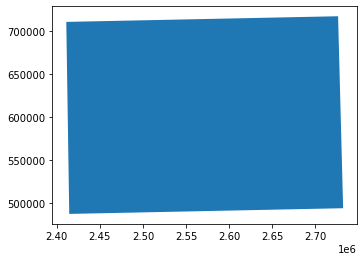

In [6]:
west, south, east, north = stores.total_bounds
west, south, east, north
coords = [(-84.4989212, 36.2751106), (-84.4989212, 35.6625308), (-83.4280304, 35.6625308), (-83.4280304, 36.2751106)]
polygon = Polygon(coords)
bbox = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])
bbox_gdf = bbox_gdf.copy(deep=True).to_crs(2274) # The TN Buildings Footprint shapefile is set to CRS 2274
bbox_gdf.plot()
west, south, east, north

#### Load East TN Building Footprints dataset 

In [5]:
tn_east_bldgs = gpd.read_file(r'C:\Users\jfeng\Downloads\Tennessee_USGS_3DEP_19County_2016_QL2_BuildingFootprints\Tennessee_USGS_3DEP_19County_2016_QL2_BuildingFootprints\TNEast_Buildings.shp', index_col=True)
tn_east_bldgs.head(5)

,Shape_Leng,Shape_Area,geometry
0,131.509581,962.706730,"POLYGON ((2760138.250 588000.250, 2760094.500 ..."
1,177.211953,1902.694330,"POLYGON ((2794926.497 588003.412, 2794901.002 ..."
2,165.666951,1670.459643,"POLYGON ((2782817.429 588036.700, 2782808.294 ..."
3,154.499037,1122.256418,"POLYGON ((2794450.871 588032.941, 2794397.530 ..."
4,142.141387,1205.021142,"POLYGON ((2762050.461 588016.288, 2762025.769 ..."


#### Query building footprints to area in/around Knox County by filtering with a bounding box
https://gis.stackexchange.com/questions/266730/filter-by-bounding-box-in-geopandas

<AxesSubplot:>

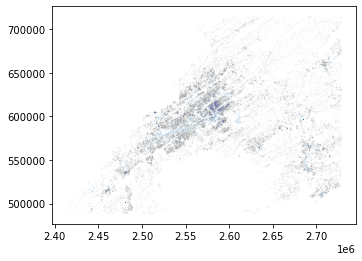

In [6]:
knox_bldgs = tn_east_bldgs.cx[west:east, south:north]
knox_bldgs.plot()

#### Generate Voronoi tessellation around building polygons
http://docs.momepy.org/en/stable/user_guide/elements/tessellation.html

In [7]:
# Reset the index
knox_bldgs = knox_bldgs.reset_index(drop=True)
# Create a unique object ID column which serves as a link to a generated cell/voronoi polygon
knox_bldgs["ID"] = knox_bldgs.index.map(hash)
knox_bldgs

,Shape_Leng,Shape_Area,geometry,ID
0,146.472032,1325.505229,"POLYGON ((2433987.949 488237.014, 2433960.916 ...",0
1,140.503438,1200.550563,"POLYGON ((2444263.751 488252.335, 2444243.706 ...",1
2,296.552512,3522.034024,"POLYGON ((2446036.979 488270.052, 2445993.540 ...",2
3,154.552600,1477.265217,"POLYGON ((2417556.654 488272.226, 2417538.775 ...",3
4,292.550827,4080.731415,"POLYGON ((2424122.423 488235.822, 2424086.223 ...",4
...,...,...,...,...
290390,910.009584,18862.533979,"POLYGON ((2606452.457 639620.166, 2606465.952 ...",290390
290391,211.136798,2089.859660,"POLYGON ((2605312.884 648819.073, 2605296.354 ...",290391
290392,429.352540,6728.689192,"POLYGON ((2628305.124 665834.486, 2628320.959 ...",290392
290393,217.552814,1946.290073,"POLYGON ((2605044.280 671774.177, 2605056.070 ...",290393


In [ ]:
tessellation = momepy.Tessellation(knox_bldgs, unique_id='ID', limit=bbox_gdf, verbose=True)
tessellation_gdf = tessellation.tessellation

knox_bldgs.to_file('../Data/Knox_County_Building_Footprints.shp')
tessellation.to_file('../Data/Knox_County_Building_Tessellation.shp')

Inward offset...
Generating input point array...
Generating Voronoi diagram...


In [ ]:
graph = ox.graph_from_bbox(north=n, south=s, east=e, west=w,
                           network_type="all",
                           retain_all=True,
                           truncate_by_edge=True)

graph = ox.add_edge_speeds(graph)
graph = ox.add_edge_travel_times(graph)

graph_projected = ox.project_graph(graph)
ox.save_graph_shapefile(graph_projected, filepath='../Data/OSM_Network')

# place_name = "Knox County, Tennessee, United States of America"
# graph = ox.graph_from_place(place_name)

In [2]:
# Convert shapefile to geojson

from osgeo import gdal

def shapefile2geojson(infile, outfile):

    options = gdal.VectorTranslateOptions(format="GeoJSON", dstSRS="EPSG:4326")
    gdal.VectorTranslate(outfile, infile, options=options)

In [4]:
infile = "../Data/OSM_Network/edges.shp"
outfile = "../Data/OSM_Network/edges.geojson"

shapefile2geojson(infile, outfile)

infile = "../Data/OSM_Network/nodes.shp"
outfile = "../Data/OSM_Network/nodes.geojson"

shapefile2geojson(infile, outfile)

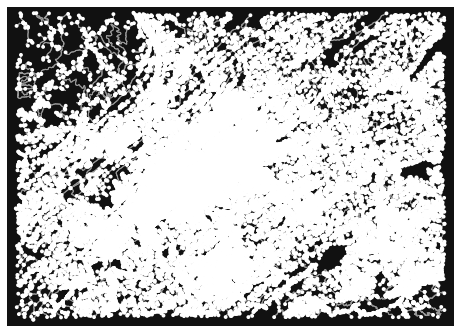

In [17]:
# Plot the streets
fig, ax = ox.plot_graph(graph)

<AxesSubplot:>

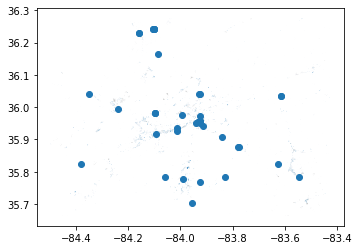

In [36]:
buildings = ox.geometries_from_bbox(north=bbox[3], south=bbox[1], east=bbox[2], west=bbox[0], tags={'building':True})
buildings.plot()

In [39]:
fig, ax = ox.plot_graph(graph, ax=ax, bbox=bbox, edge_color='#F4FF6E', show=False)
fig, ax = ox.plot_footprints(buildings, ax=ax, bbox=bbox, color='#F4FF6E', save=True)

<Figure size 432x288 with 0 Axes>

In [35]:
buildings_proj = ox.project_gdf(buildings)
buildings_proj.area

0      2204.155839
1       351.573200
2       279.918791
3       338.541477
4       405.093412
          ...     
227     624.519365
228     877.552674
229     192.523112
230    1557.482816
231    8190.276618
Length: 232, dtype: float64

In [48]:
tn_east_bldgs.crs

C:\Users\jfeng\Anaconda3\envs\hagerstrand\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Tennessee - counties of Anderson; Bedford; Benton; Bledsoe; Blount; Bradley; Campbell; Cannon; Carroll; Carter; Cheatham; Chester; Claiborne; Clay; Cocke; Coffee; Crockett; Cumberland; Davidson; De Kalb; Decatur; Dickson; Dyer; Fayette; Fentress; Franklin; Gibson; Giles; Grainger; Greene; Grundy; Hamblen; Hamilton; Hancock; Hardeman; Hardin; Hawkins; Haywood; Henderson; Henry; Hickman; Houston; Humphreys; Jackson; Jefferson; Johnson; Knox; Lake; Lauderdale; Lawrence; Lewis; Lincoln; Loudon; Macon; Madison; Marion; Marshall; Maury; McMinn; McNairy; Meigs; Monroe; Montgomery; Moore; Morgan; Obion; Overton; Perry; Pickett; Polk; Putnam; Rhea; Roane; Robertson; Rutherford; Scott; Sequatchie; Sevier; Shelby; Smith; Stewart; Sullivan; Sumner; Tipton; Trousdale; Unicoi; Union; Van Buren; Warren; Wa

# Isochrones

In [2]:
stores = gpd.read_file('../Data/Grocery_Stores_20220224.shp', encoding='ISO-8859-1', index_col=True)
w, s, e, n = stores.total_bounds
stores = stores.to_crs(32617)

# https://stackoverflow.com/questions/62789846/isochrones-with-osmnx
# https://stackoverflow.com/questions/59692619/generate-weighted-graph-from-osmnx-for-networkx

In [83]:
def osmnx_graph(north, south, east, west, network_type, speed=0):
    graph = ox.graph_from_bbox(north=north, south=south, east=east, west=west,
                           network_type='drive',
                           retain_all=True,
                           truncate_by_edge=True)
    if speed == 0:
        #graph = ox.project_graph(graph)
        # Impute speeds on edges missing data
        graph = ox.add_edge_speeds(graph)
        # Or assign speeds to edges missing data based on dict values.
        # For edges with highway type not in dict, impute speeds.
        # hwy_speeds = {'motorway': 100,
        #               'trunk': 100,
        #               'residential': 60,
        #               'tertiary': 60} #etc
        # Add travel time along edges
        graph = ox.add_edge_travel_times(graph)
    # OSMNX often treats residential roads as car-roads and not footways...
    # So we have to go with a drive network type and divide the segments with appropriate speeds for other travel modes
    else:
        # Project the graph to UTM
        #graph = ox.project_graph(graph) # UTM Zone 17N / WGS84
        # graph.graph['crs'] # If you don't set the crs, it automatically uses the UTM Zone of the centroid of the network
        # Add an edge attribute for time in minutes required to traverse each edge
        kilometers_per_second = speed / 3600 # km per hour to km per second
        for _, _, _, data in graph.edges(data=True, keys=True):
            data["travel_time"] = (data["length"]/1000) / kilometers_per_second
        print('Not drive')
            
    nodes_gdf = ox.graph_to_gdfs(graph, edges=False)
    edges_gdf = ox.graph_to_gdfs(graph, nodes=False)
    
    return graph, nodes_gdf, edges_gdf

In [86]:
G_drive, G_nodes_drive, G_edges_drive = osmnx_graph(n, s, e, w, 'drive')
G_walk, G_nodes_walk, G_edges_walk = osmnx_graph(n, s, e, w, 'walk', 5.6327)
G_bike, G_nodes_bike, G_edges_bike = osmnx_graph(n, s, e, w, 'bike', 22.5308)

Not drive
Not drive


In [13]:
# Retrieve nearest node for each store
stores_nearest_nodes = []
for store_geom in stores['geometry']:
    stores_nearest_nodes.append(ox.distance.nearest_nodes(graph, store_geom.x, store_geom.y))

stores_nearest_nodes[0:5]
center_node = stores_nearest_nodes[0]

[2867321799, 8507189861, 3083998622, 202898430, 202900441]

In [10]:
traj = pd.read_csv('../Data/Scenarios_Synthetic_Data_Trajectories.csv', index_col=0)
traj.head(5)

,person_id,latlon,time,sequence,poi_type,activity_type,travel_type,latitude,longitude,datetime,latlon_shift,node_id_o,node_id_d
0,1,"36.017275180220686, -83.9789496929944",3/11/2022 0:00,1,home,home,stay,36.017275,-83.978950,2022-03-11 00:00:00,"36.017275180220686, -83.9789496929944",13165,13165
1,1,"36.017275180220686, -83.9789496929944",3/11/2022 8:45,2,travel,drive,drive,36.017271,-83.978650,2022-03-11 08:45:02,"36.00855266240395, -84.00900907740508",13165,6078
2,1,"36.017275180220686, -83.9789496929944",3/11/2022 8:45,3,travel,drive,drive,36.017587,-83.978618,2022-03-11 08:45:03,"36.00855266240395, -84.00900907740508",6078,13166
3,1,"36.017275180220686, -83.9789496929944",3/11/2022 8:45,4,travel,drive,drive,36.017631,-83.979106,2022-03-11 08:45:04,"36.00855266240395, -84.00900907740508",13166,17529
4,1,"36.017275180220686, -83.9789496929944",3/11/2022 8:45,5,travel,drive,drive,36.016919,-83.980455,2022-03-11 08:45:05,"36.00855266240395, -84.00900907740508",17529,6838


In [ ]:
traj_nearest = traj.drop_duplicates(['longitude','latitude'])
traj_nearest['nearest_node'] = nearest_nodes
traj_nearest = pd.merge(traj, traj_nearest[['latitude','longitude','nearest_node']], left_on=['latitude','longitude'], right_on=['latitude','longitude'], how='left')
traj_nearest.to_csv('../Data/Scenarios_Synthetic_Data_Trajectories_Nearest_Node.csv')

In [2]:
nonfixed_df = pd.read_csv('../Data/Scenarios_Synthetic_Data_Nonfixed_Times.csv', index_col = 0); nonfixed_df

,person_id,latlon_start,free_time_start,travel_type,latlon_end,free_time_end,time_available,lat_start,lon_start,lat_end,lon_end
0,1,"36.037151547762804, -83.88836923955422",3/12/2022 15:27,drive,"36.017275180220686, -83.9789496929944",3/12/2022 19:00,213,36.037152,-83.888369,36.017275,-83.978950
1,2,"35.98349169566448, -83.86571214720897",3/11/2022 11:51,drive,"35.984050920293654, -83.86389072399044",3/11/2022 12:11,20,35.983492,-83.865712,35.984051,-83.863891
2,2,"35.98609435245885, -83.87576239278165",3/12/2022 10:11,drive,"35.98609435245885, -83.87576239278165",3/12/2022 18:00,469,35.986094,-83.875762,35.986094,-83.875762
3,3,"35.95808867715242, -83.90426963986357",3/12/2022 11:59,walk,"35.95808867715242, -83.90426963986357",3/12/2022 17:00,301,35.958089,-83.904270,35.958089,-83.904270
4,4,"35.934019762725534, -84.07721548710211",3/11/2022 7:37,drive,"35.91882993729321, -84.0849734823089",3/11/2022 16:22,525,35.934020,-84.077215,35.918830,-84.084973
...,...,...,...,...,...,...,...,...,...,...,...
89,49,"36.115853432569125, -83.84687525427256",3/12/2022 13:21,drive,"36.09298191895682, -83.91772071314563",3/12/2022 14:51,90,36.115853,-83.846875,36.092982,-83.917721
90,50,"35.9209706249943, -83.92200228622752",3/12/2022 10:20,walk,"35.921644425964494, -83.9217572914168",3/12/2022 16:00,340,35.920971,-83.922002,35.921644,-83.921757
91,51,"35.989834534715314, -83.88727893651156",3/12/2022 19:36,drive,"36.019933887029055, -83.90746798386454",3/12/2022 21:00,84,35.989835,-83.887279,36.019934,-83.907468
92,52,"35.975120762595296, -83.91538082696736",3/11/2022 19:15,drive,"35.94836293008667, -83.91029919331599",3/11/2022 20:00,45,35.975121,-83.915381,35.948363,-83.910299


In [38]:
from scipy.spatial import Delaunay
import numpy as np
from shapely.ops import polygonize, cascaded_union
from shapely.geometry import MultiLineString
import pygeos
import geopandas as gpd

def concave_hull(points_gdf, alpha=100):
    """
    Compute the concave hull (alpha shape) of a GeoDataFrame of points.
    
    https://gist.github.com/HTenkanen/49528990d1ab4bcb5562ba01ba6262ef
    
    Parameters
    ==========
    points_gdf : gpd.GeoDataFrame
      GeoDataFrame of points.
    
    alpha: int
    
      alpha value to influence the gooeyness of the border. Smaller numbers
      don't fall inward as much as larger numbers. Too large, and you lose everything!
    """
    if len(points_gdf) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return points_gdf.unary_union.convex_hull

    coords = pygeos.coordinates.get_coordinates(points_gdf.geometry.values.data)
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)]
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return gpd.GeoDataFrame({"geometry": [cascaded_union(triangles)]}, index=[0], crs=points_gdf.crs)

def dppa(graph, lon, lat, trip_time):
    '''
    Derive the potential path area between fixed points and times
    '''
    # Add time required for travel to end point. Retrieve shortest path between start and end points -- the person ultimately needs to travel there
    # Add 45 minutes (average grocery shopping time) based on 2019 Time Use Survey: https://www.bls.gov/tus/a1-2019.pdf
    # Find nearest node to each unique trajectory stop
    node = ox.distance.nearest_nodes(graph, lon, lat)
    subgraph = nx.ego_graph(graph, node, radius=trip_time, distance='travel_time')
    points = pd.DataFrame([(data['x'], data['y']) for _, data in subgraph.nodes(data=True)], columns=['x', 'y'])
    point_geoms = gpd.GeoSeries(points.apply(geometry.Point, axis='columns'))
    point_geoms.crs = 'epsg:32617'
    bounding_poly = concave_hull(point_geoms)
    #bounding_poly = alphashape.alphashape(point_geoms) #Takes too long
    return bounding_poly

def dppa_kuan(graph, lon, lat, trip_time, infill=True):
    '''
    Derive the potential path area between fixed points and times.
    Inspiration from http://kuanbutts.com/2017/12/16/osmnx-isochrones/
    '''
    # Add time required for travel to end point. Retrieve shortest path between start and end points -- the person ultimately needs to travel there
    # Add 45 minutes (average grocery shopping time) based on 2019 Time Use Survey: https://www.bls.gov/tus/a1-2019.pdf
    # Find nearest node to each unique trajectory stop
    node = ox.distance.nearest_nodes(graph, lon, lat)
    subgraph = nx.ego_graph(graph, node, radius=trip_time, distance='travel_time')
    points = [Point((data['x'], data['y'])) for _, data in subgraph.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=points)
    nodes_gdf = nodes_gdf.set_index('id')
    
    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lines.append(LineString([f,t]))
    
    node_buff=50
    edge_buff=50
    
    n = nodes_gdf.buffer(node_buff).geometry
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).unary_union   

    # new_iso_ddf = dask_geopandas.from_geopandas(e, npartitions=8)
    # u = new_iso_ddf.unary_union
    # u.compute()
    # return u
    
    if infill:
        new_iso = Polygon(new_iso.exterior)
    #isochrone_polys.append(new_iso)    
    
    # point_geoms = gpd.GeoSeries(points.apply(geometry.Point, axis='columns'))
    # point_geoms.crs = 'epsg:32617'
    # bounding_poly = concave_hull(point_geoms)
    #bounding_poly = alphashape.alphashape(point_geoms) #Takes too long
    
    return new_iso

In [9]:
import dask_geopandas
from dask.distributed import Client, LocalCluster

client = Client(
    LocalCluster(
        n_workers=8, 
        threads_per_worker=1
    )
)

In [3]:
G_drive_project = ox.project_graph(G_drive)
G_walk_project = ox.project_graph(G_walk)
G_bike_project = ox.project_graph(G_bike)

In [4]:
nonfixed_proj = gpd.GeoDataFrame(nonfixed_df,
                                 geometry=gpd.points_from_xy(nonfixed_df.lat_start, nonfixed_df.lon_start),
                                 crs=4326)
# Project to UTM Zone 17N, just like the OSMNX graphs
nonfixed_proj = nonfixed_proj.to_crs(32617)
nonfixed_proj 

,person_id,latlon_start,free_time_start,travel_type,latlon_end,free_time_end,time_available,lat_start,lon_start,lat_end,lon_end,geometry
0,1,"36.037151547762804, -83.88836923955422",3/12/2022 15:27,drive,"36.017275180220686, -83.9789496929944",3/12/2022 17:11,213,36.037152,-83.888369,36.017275,-83.978950,POINT (1108438.703 -10309068.041)
1,2,"35.98349169566448, -83.86571214720897",3/11/2022 11:51,drive,"35.984050920293654, -83.86389072399044",3/11/2022 12:00,20,35.983492,-83.865712,35.984051,-83.863891,POINT (1110992.579 -10309656.007)
2,2,"35.98609435245885, -83.87576239278165",3/12/2022 10:11,drive,"35.98609435245885, -83.87576239278165",3/12/2022 14:56,469,35.986094,-83.875762,35.986094,-83.875762,POINT (1109975.185 -10309169.996)
3,3,"35.95808867715242, -83.90426963986357",3/12/2022 11:59,walk,"35.95808867715242, -83.90426963986357",3/12/2022 14:03,301,35.958089,-83.904270,35.958089,-83.904270,POINT (1107281.715 -10307415.880)
4,4,"35.934019762725534, -84.07721548710211",3/11/2022 7:37,drive,"35.91882993729321, -84.0849734823089",3/11/2022 16:07,525,35.934020,-84.077215,35.918830,-84.084973,POINT (1090143.470 -10298338.364)
...,...,...,...,...,...,...,...,...,...,...,...,...
89,49,"36.115853432569125, -83.84687525427256",3/12/2022 13:21,drive,"36.09298191895682, -83.91772071314563",3/12/2022 14:41,90,36.115853,-83.846875,36.092982,-83.917721,POINT (1112145.933 -10312034.364)
90,50,"35.9209706249943, -83.92200228622752",3/12/2022 10:20,walk,"35.921644425964494, -83.9217572914168",3/12/2022 10:20,340,35.920971,-83.922002,35.921644,-83.921757,POINT (1105711.921 -10306117.892)
91,51,"35.989834534715314, -83.88727893651156",3/12/2022 19:36,drive,"36.019933887029055, -83.90746798386454",3/12/2022 19:36,84,35.989835,-83.887279,36.019934,-83.907468,POINT (1108805.301 -10308621.039)
92,52,"35.975120762595296, -83.91538082696736",3/11/2022 19:15,drive,"35.94836293008667, -83.91029919331599",3/11/2022 19:15,45,35.975121,-83.915381,35.948363,-83.910299,POINT (1106080.182 -10307028.718)


# Derive potential path area for each person based on their flexible+available time

from tqdm import tqdm

isochrones = []
for idx, row in tqdm(nonfixed_proj.iterrows(), total=nonfixed_df.shape[0]):

    if row['travel_type'] == 'drive':
        isochrones.append(dppa_kuan(G_drive_project, row['geometry'].x, row['geometry'].y, row['time_available']*60))
    elif row['travel_type'] == 'walk':
        isochrones.append(dppa_kuan(G_walk_project, row['geometry'].x, row['geometry'].y, row['time_available']*60))
    elif row['travel_type'] == 'bike':
        isochrones.append(dppa_kuan(G_bike_project, row['geometry'].x, row['geometry'].y, row['time_available']*60))
    else:
        isochrones.append(None)
    break
isochrones_gdf = gpd.GeoDataFrame(geometry=isochrones)
isochrones_gdf.plot()

In [39]:
# Derive potential path area for each person based on their flexible+available time

from tqdm import tqdm

nonfixed_gdf = gpd.GeoDataFrame()
for idx, row in tqdm(nonfixed_df.iterrows(), total=nonfixed_df.shape[0]):

    if row['travel_type'] == 'drive':
        nonfixed_gdf = nonfixed_gdf.append(dppa(G_drive, row['lon_start'], row['lat_start'], row['time_available']*60))
    elif row['travel_type'] == 'walk':
        nonfixed_gdf = nonfixed_gdf.append(dppa(G_walk, row['lon_start'], row['lat_start'], row['time_available']*60))
    elif row['travel_type'] == 'bike':
        nonfixed_gdf = nonfixed_gdf.append(dppa(G_bike, row['lon_start'], row['lat_start'], row['time_available']*60))
    else:
        nonfixed_gdf = nonfixed_gdf.append(None)

nonfixed_gdf = nonfixed_gdf.reset_index(drop=True)
nonfixed_gdf = pd.merge(nonfixed_gdf, nonfixed_df, left_index=True, right_index=True)
#nonfixed_gdf.to_file('../Data/Scenario_Flexible_Space_Time_Prisms.shp')

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [18:57<00:00, 12.10s/it]


In [5]:
from shapely import wkt

stores['geometry'] = stores['geometry'].apply(wkt.loads)
stores_gdf = gpd.GeoDataFrame(stores, geometry=stores.geometry, crs=4326)

In [46]:
prisms_stores = gpd.sjoin(nonfixed_gdf, stores_gdf).groupby(['person_id', 'free_time_start']).size().reset_index()
prisms_stores.columns = ['person_id', 'free_time_start', 'StoreOpps']
prisms_stores = pd.merge(nonfixed_gdf, prisms_stores['StoreOpps'], left_index=True, right_index=True)
# nonfixed_gdf.fillna('', inplace=True)

# Set datetime type for relevant columns
cols2 = ['free_time_start', 'free_time_end']
nonfixed_gdf[cols2] = nonfixed_gdf[cols2].apply(pd.to_datetime, errors='coerce')
prisms_stores['free_time_start'] = prisms_stores['free_time_start'].dt.strftime('%Y-%m-%d %H:%m:%s')
prisms_stores['free_time_end'] = prisms_stores['free_time_end'].dt.strftime('%Y-%m-%d %H:%m:%s')
prisms_stores.to_file('../Data/Scenario_Flexible_Space_Time_Prisms.shp')
#nonfixed_gdf.to_file()

<ipython-input-46-5da1f58690e0>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  prisms_stores = gpd.sjoin(nonfixed_gdf, stores_gdf).groupby(['person_id', 'free_time_start']).size().reset_index()
<ipython-input-46-5da1f58690e0>:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  prisms_stores.to_file('../Data/Scenario_Flexible_Space_Time_Prisms.shp')


In [25]:
people = pd.read_csv('../Data/People_Synthetic_Data.csv'); people.head(5)

,person_id,age,sex,raceethnic,incomeyear,language,dietarypref,digitallit,job,housing,housesize,kidsathome,marital,travelmode,physical,snapbenefit,cost_pref,other_pref,dimension,description
0,1,36,f,hispanic,40320,"spanish, english",hispanic,no,cook,rent,3,2,divorced,drive,NaN,no,$,NaN,{'affordability': 'mental'},Single Hispanic immigrant mother with two teen...
1,2,64,m,black,35122,english,NaN,no,"retired, volunteer",own,3,0,single,drive,NaN,no,$$,NaN,{'accessibility': 'relative'},Retired black male school teacher with small s...
2,3,25,m,white,28685,english,NaN,no,"janitor, student",rent,1,0,single,"transit, walk",NaN,no,$,NaN,{'accommodation': 'relative'},Single white man with a GED who works night-ti...
3,4,53,m,asian,22000,vietnamese,asian,no,cook,own,2,1,widowed,drive,NaN,no,$,NaN,{'availability': 'relative'},Widowed male immigrant from Vietnam paying mor...
4,5,20,f,middleeast,6000,"arabic, english",halal,yes,"student, assistant",rent,1,0,single,"transit, walk",NaN,no,$,NaN,{'availability': 'relative'},International female student from Kuwait livin...


In [54]:
nonfixed_gdf = pd.merge(nonfixed_gdf, people, left_on='person_id', right_on='person_id')
nonfixed_gdf.fillna('', inplace=True)

In [50]:
# Load all stores (convenience, grocery, wholesale)
stores = pd.read_csv('../Data/All_Food_Stores_Features.csv', index_col = 0)

# Convert opening hours to datetime type
cols = ['Tuesday_Open', 'Tuesday_Close',
       'Wednesday_Open', 'Wednesday_Close', 'Thursday_Open',
       'Thursday_Close', 'Friday_Open', 'Friday_Close', 'Saturday_Open',
       'Saturday_Close', 'Sunday_Open', 'Sunday_Close', 'Monday_Open',
       'Monday_Close']
stores[cols] = stores[cols].apply(pd.to_datetime, errors='coerce')
stores

,Name,Rating,Price,Type,Address,Hours,Website,Phone,PlusCode,Descript,...,Thursday_Open,Thursday_Close,Friday_Open,Friday_Close,Saturday_Open,Saturday_Close,Sunday_Open,Sunday_Close,Monday_Open,Monday_Close
0,United Grocery Outlet,4.3,NaN,Grocery store,"1210 E Broadway St, Lenoir City, TN 37772","{'Tuesday': ['8AM', '7PM'], 'Wednesday': ['8AM...",Website: myugo.com,(865) 986-2471,"QPXW+J6 Lenoir City, Tenn",NaN,...,2022-03-10 08:00:00,2022-03-10 19:00:00,2022-03-11 08:00:00,2022-03-11 19:00:00,2022-03-12 08:00:00,2022-03-12 19:00:00,2022-03-13 10:00:00,2022-03-13 18:00:00,2022-03-14 08:00:00,2022-03-14 19:00:00
1,Ingles Markets,4.3,$$,Grocery store,"11847 Kingston Pike, Knoxville, TN 37934","{'Tuesday': ['6AM', '11PM'], 'Wednesday': ['6A...",Website: ingles-markets.com,(865) 966-4360,"VRFC+WR Knoxville, Tenn",NaN,...,2022-03-10 06:00:00,2022-03-10 23:00:00,2022-03-11 06:00:00,2022-03-11 23:00:00,2022-03-12 06:00:00,2022-03-12 23:00:00,2022-03-13 06:00:00,2022-03-13 23:00:00,2022-03-14 06:00:00,2022-03-14 23:00:00
2,Ingles Markets,4.4,$$,Supermarket,"404 US-321 #1, Lenoir City, TN 37771","{'Tuesday': ['6AM', '11PM'], 'Wednesday': ['6A...",Website: ingles-markets.com,(865) 988-5902,"RP2P+RV Lenoir City, Tenn",NaN,...,2022-03-10 06:00:00,2022-03-10 23:00:00,2022-03-11 06:00:00,2022-03-11 23:00:00,2022-03-12 06:00:00,2022-03-12 23:00:00,2022-03-13 06:00:00,2022-03-13 23:00:00,2022-03-14 06:00:00,2022-03-14 23:00:00
3,ALDI,4.5,$,Supermarket,"725 US Hwy 321 N, Lenoir City, TN 37771","{'Tuesday': ['8:30AM', '8PM'], 'Wednesday': ['...",Website: aldi.us,(855) 955-2534,"RP6P+MW Lenoir City, Tenn","Retail chain selling a range of grocery items,...",...,2022-03-10 08:30:00,2022-03-10 20:00:00,2022-03-11 09:00:00,2022-03-11 20:00:00,2022-03-12 09:00:00,2022-03-12 20:00:00,2022-03-13 09:00:00,2022-03-13 20:00:00,2022-03-14 09:00:00,2022-03-14 20:00:00
4,Walmart Supercenter,3.9,$,Department store,"911 Highway 321 N, Lenoir City, TN 37771","{'Tuesday': ['6AM', '11PM'], 'Wednesday': ['6A...",Website: walmart.com,(865) 986-9002,"RPCP+R5 Lenoir City, Tenn",NaN,...,2022-03-10 06:00:00,2022-03-10 23:00:00,2022-03-11 06:00:00,2022-03-11 23:00:00,2022-03-12 06:00:00,2022-03-12 23:00:00,2022-03-13 06:00:00,2022-03-13 23:00:00,2022-03-14 06:00:00,2022-03-14 23:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,E-Z Stop Food Marts,3.0,NaN,Convenience store,"7503 Tazewell Pike, Corryton, TN 37721","{'Monday': ['Open 24 hours'], 'Tuesday': ['Ope...",Website: ezstop.net,(865) 689-2688,"44CW+G9 Corryton, Tenn",NaN,...,2022-03-10 00:00:00,2261-12-31 00:00:00,2022-03-11 00:00:00,2261-12-31 00:00:00,2022-03-12 00:00:00,2261-12-31 00:00:00,2022-03-13 00:00:00,2261-12-31 00:00:00,2022-03-14 00:00:00,2261-12-31 00:00:00
217,By-Lo Market,2.6,NaN,Convenience store,"10711 Rutledge Pike, Blaine, TN 37709","{'Monday': ['Open 24 hours'], 'Tuesday': ['Ope...",NaN,(865) 933-2028,"47HH+4J Blaine, Tenn",NaN,...,2022-03-10 00:00:00,2261-12-31 00:00:00,2022-03-11 00:00:00,2261-12-31 00:00:00,2022-03-12 00:00:00,2261-12-31 00:00:00,2022-03-13 00:00:00,2261-12-31 00:00:00,2022-03-14 00:00:00,2261-12-31 00:00:00
218,Dollar General,4.1,$,Dollar store,"256 Rutledge Pike, Blaine, TN 37709","{'Monday': ['8AM', '10PM'], 'Tuesday': ['8AM',...",Website: stores.dollargeneral.com,(865) 401-0029,"47PP+P4 Blaine, Tenn",Bargain retail chain selling a range of househ...,...,2022-03-10 08:00:00,2022-03-10 22:00:00,2022-03-11 08:00:00,2022-03-11 22:00:00,2022-03-12 08:00:00,2022-03-12 22:00:00,2022-03-13 08:00:00,2022-03-13 22:00:00,2022-03-14 08:00:00,2022-03-14 22:00:00
219,Costco Wholesale,4.6,$$,Warehouse store,"10745 Kingston Pike, Knoxville, TN 37934","{'Friday': ['10AM', '8:30PM'], 'Saturday': ['9...",Website: costco.com,(865) 218-7700,"VVW5+MQ Knoxville, Tenn",Members-only warehouse selling a huge variety ...,...,2022-03-10 10:00:00,2022-03-10 20:30:00,2022-03-11 10:00:00,2022-03-11 20:30:00,2022-03-12 09:30:00,2022-03-12 18:00:00,2022-0

In [35]:
# Person IDs of People who use transit
transit_people = [i for i in nonfixed_df[nonfixed_df['travel_type'] == 'walk']['person_id'].unique() if 'transit' in people.loc[i-1, 'travelmode']]
gtfs_folder = "../Data/GTFS_Knoxville_Area_Transit"

# Test of Google Maps Directions API

# gmaps.directions(origin='Brooklyn%2C%20New%20York',
#                  destination='Manhattan%2C%20New%20York',#'QPXW+J6 Lenoir City, Tenn'.replace('+', '%2B').replace(' ', '%20').replace(',', ''),
#                  mode='transit',
#                  arrival_time=datetime.now())

In [65]:
# Calculate time from start to store [DONE]
# Calculate time from store to end [DONE]
# https://www.grocerydive.com/news/h-e-b-whole-foods-have-fastest-pickup-times-study-says/566152/
# The study found the average wait time for in-store grocery pickup is 4 minutes, 3 seconds
# For curbside pickup, the average wait time was 5 minutes, 21 seconds
# If other_pref = Store pickup: add 243 seconds [DONE]
# Average of curbside + in-store pickup is 4 minutes, 42 seconds
# If other_pref = Delivery: skip finding physical stores
# Otherwise, we assume they shop in store, so add 45 mins * 60 seconds

od = pd.DataFrame()
# From each of these points, calculate the shortest time to each POI and add 45 minutes for the act of grocery shopping; if there's enough time, POI is in the feasible opportunity set, otherwise, it is not.

for idx, row in nonfixed_gdf.iterrows():
    
    time_activity = 0
    if 'store pickup' in row['other_pref'].lower():
        time_activity = 282
    elif 'delivery' in row['other_pref'].lower():
        next
    else:
        time_activity = 45 * 60 # 45 minutes to seconds
    
    if row['travel_type'] == 'drive':
        G = G_drive
    elif row['travel_type'] == 'bike':
        G = G_bike
    elif row['travel_type'] == 'walk':
        G = G_walk
    
    w = 'travel_time'
    node_start = ox.distance.nearest_nodes(G, row['lon_start'], row['lat_start'])
    node_end = ox.distance.nearest_nodes(G, row['lon_end'], row['lat_end'])
    
    od_list = []
    
   
    for idx_s, row_s in stores.iterrows():
        
        if row['travel_type'] in ['drive','bike','walk']:
        
            node_store = ox.distance.nearest_nodes(G, row_s['Longitude'], row_s['Latitude'])
            travel_time_to = nx.shortest_path_length(G, node_start, node_store, weight=w)

            travel_time_back = travel_time_to
            # Assume same route back if end destination is same as start origin
            if row['latlon_end'] != row['latlon_start']:
                travel_time_back = nx.shortest_path_length(G, node_store, node_end, weight=w)

            if row['travel_type'] == 'transit':
                try:
                    gmapdirs = gmaps.directions(origin=row['latlon_start'].replace(',', '%2C'),
                                     destination=row['latlon_store'].replace(',', '%2C'),#'QPXW+J6 Lenoir City, Tenn'.replace('+', '%2B').replace(' ', '%20').replace(',', ''),
                                     mode='transit',
                                     departure_time=row['free_time_start'].timestamp())
                    travel_time_to = gmapdirs[0]['legs'][0]['duration']['value']
                except googlemaps.exceptions.ApiError as err:
                    pass

                try:
                    gmapdirs = gmaps.directions(origin=row['latlon_store'].replace(',', '%2C'),
                                     destination=row['latlon_end'].replace(',', '%2C'),#'QPXW+J6 Lenoir City, Tenn'.replace('+', '%2B').replace(' ', '%20').replace(',', ''),
                                     mode='transit',
                                     arrival_time=row['free_time_send'].timestamp())
                    travel_time_back = gmapdirs[0]['legs'][0]['duration']['value']
                except googlemaps.exceptions.ApiError as err:
                    pass                      
                
            can_visit_general = False
            if (travel_time_to + time_activity + travel_time_back) <= row['time_available']*60:
                can_visit_general = True

            # For each flexible time period in an individual's daily life
            # (1) If the time they are available + the travel time required to get to a store is later than or equal to the opening time of the store AND
            # (2) If the time they are available + the travel time required to get to a store + the time required for getting their groceries + the travel time required to get to their next location for a mandatory activity is earlier than or equal to the closing time of the store AND
            # (3) If they have enough available time
            # Then the store is accessible based on their time constraints
            can_visit_daytime = False
            if (row['free_time_start'].weekday() == 0):
                if (row_s['Monday_Open'] <= row['free_time_start'] + pd.Timedelta(seconds=travel_time_to)) & (row['free_time_start'] + pd.Timedelta(seconds=travel_time_to + time_activity + travel_time_back) <= row_s['Monday_Close']) & can_visit_general:
                    can_visit_daytime = True        
            elif (row['free_time_start'].weekday() == 1):
                if (row_s['Tuesday_Open'] <= row['free_time_start'] + pd.Timedelta(seconds=travel_time_to)) & (row['free_time_start'] + pd.Timedelta(seconds=travel_time_to + time_activity + travel_time_back) <= row_s['Tuesday_Close']) & can_visit_general:
                    can_visit_daytime = True        
            elif (row['free_time_start'].weekday() == 2):
                if (row_s['Wednesday_Open'] <= row['free_time_start'] + pd.Timedelta(seconds=travel_time_to)) & (row['free_time_start'] + pd.Timedelta(seconds=travel_time_to + time_activity + travel_time_back) <= row_s['Wednesday_Close']) & can_visit_general:
                    can_visit_daytime = True                
            elif (row['free_time_start'].weekday() == 3):
                if (row_s['Thursday_Open'] <= row['free_time_start'] + pd.Timedelta(seconds=travel_time_to)) & (row['free_time_start'] + pd.Timedelta(seconds=travel_time_to + time_activity + travel_time_back) <= row_s['Thursday_Close']) & can_visit_general:
                    can_visit_daytime = True        
            elif (row['free_time_start'].weekday() == 4):
                if (row_s['Friday_Open'] <= row['free_time_start'] + pd.Timedelta(seconds=travel_time_to)) & (row['free_time_start'] + pd.Timedelta(seconds=travel_time_to + time_activity + travel_time_back) <= row_s['Friday_Close']) & can_visit_general:
                    can_visit_daytime = True
            elif (row['free_time_start'].weekday() == 5):
                if (row_s['Saturday_Open'] <= row['free_time_start'] + pd.Timedelta(seconds=travel_time_to)) & (row['free_time_start'] + pd.Timedelta(seconds=travel_time_to + time_activity + travel_time_back) <= row_s['Saturday_Close']) & can_visit_general:
                    can_visit_daytime = True        
            elif (row['free_time_start'].weekday() == 6):
                if (row_s['Sunday_Open'] <= row['free_time_start'] + pd.Timedelta(seconds=travel_time_to)) & (row['free_time_start'] + pd.Timedelta(seconds=travel_time_to + time_activity + travel_time_back) <= row_s['Sunday_Close']) & can_visit_general:
                    can_visit_daytime = True    
        

#         # If the person takes transit:
#         if row['person_id'] in transit_people:
    
#             lat = row['lat_start']
#             lon = row['lon_start']
#             start_datetime = row['free_time_start'] #datetime.datetime(2022, 3, 19, 11, 59)
#             max_duration_seconds = (row['time_available'] * 60)/2 - time_activity
#             gj = gtfs.compute_isochrone(
#                     gtfs_folder, lat, lon, start_datetime, max_duration_seconds
#                 )
#             shape = gpd.GeoDataFrame.from_features(gj)
        
        
        od_list.append([row['person_id'], row['free_time_start'], row['free_time_end'], row['latlon_start'], row_s.PlusCode, row_s['Latitude'].astype(str) + ',' + row_s['Longitude'].astype(str), row['latlon_end'], travel_time_to, time_activity, travel_time_back, row['travel_type'], can_visit_general, can_visit_daytime])
    
    od = od.append(od_list)

od.rename({0:'person_id', 1:'free_time_start', 2:'free_time_end', 3:'latlon_start', 4:'store_PlusCode', 5:'latlon_store', 6:'latlon_end', 7:'time_travel_to', 8:'time_activity', 9:'time_travel_back', 10:'travel_mode', 11:'can_visit_general', 12:'can_visit_spacetime'}, axis=1, inplace=True)

In [86]:
od

,person_id,free_time_start,free_time_end,latlon_start,store_PlusCode,latlon_store,latlon_end,time_travel_to,time_activity,time_travel_back,travel_mode,can_visit_general,can_visit_spacetime
0,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","QPXW+J6 Lenoir City, Tenn","35.7990411,-84.2566213","36.017275180220686, -83.9789496929944",1935.5,2700,1702.1,drive,True,True
1,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","VRFC+WR Knoxville, Tenn","0 35.7990411,-84.2566213 1 35.874793...","36.017275180220686, -83.9789496929944",1486.9,2700,1257.3,drive,True,True
2,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","RP2P+RV Lenoir City, Tenn","0 35.7990411,-84.2566213 1 35.874793...","36.017275180220686, -83.9789496929944",1962.3,2700,1745.7,drive,True,True
3,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","RP6P+MW Lenoir City, Tenn","0 35.7990411,-84.2566213 1 35.874793...","36.017275180220686, -83.9789496929944",1845.1,2700,1628.8,drive,True,True
4,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","RPCP+R5 Lenoir City, Tenn","0 35.7990411,-84.2566213 1 35.874793...","36.017275180220686, -83.9789496929944",1769.1,2700,1549.6,drive,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20769,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","44CW+G9 Corryton, Tenn","0 35.7990411,-84.2566213 1 35.874793...","35.94836293008667, -83.91029919331599",1313.2,2700,1313.2,drive,True,True
20770,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","47HH+4J Blaine, Tenn","0 35.7990411,-84.2566213 1 35.874793...","35.94836293008667, -83.91029919331599",1483.2,2700,1483.2,drive,True,True
20771,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","47PP+P4 Blaine, Tenn","0 35.7990411,-84.2566213 1 35.874793...","35.94836293008667, -83.91029919331599",1482.4,2700,1482.4,drive,True,True
20772,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","VVW5+MQ Knoxville, Tenn","0 35.7990411,-84.2566213 1 35.874793...","35.94836293008667, -83.91029919331599",1053.8,2700,1053.8,drive,True,True


In [98]:
for i, r in od.iterrows():
    od.loc[i, 'latlon_store'] = stores[stores['PlusCode'] == r['store_PlusCode']]['Latitude'].values[0].astype(str) + ',' + stores[stores['PlusCode'] == r['store_PlusCode']]['Longitude'].values[0].astype(str)

In [101]:
od2 = pd.read_csv('../Data/OD.csv', index_col=0)

In [100]:
od.to_csv('../Data/OD_v2.csv')
od

,person_id,free_time_start,free_time_end,latlon_start,store_PlusCode,latlon_store,latlon_end,time_travel_to,time_activity,time_travel_back,travel_mode,can_visit_general,can_visit_spacetime
0,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","QPXW+J6 Lenoir City, Tenn","35.7990411,-84.2566213","36.017275180220686, -83.9789496929944",1935.5,2700,1702.1,drive,True,True
1,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","VRFC+WR Knoxville, Tenn","35.8747933,-84.1801737","36.017275180220686, -83.9789496929944",1486.9,2700,1257.3,drive,True,True
2,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","RP2P+RV Lenoir City, Tenn","35.8021016,-84.2649961","36.017275180220686, -83.9789496929944",1962.3,2700,1745.7,drive,True,True
3,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","RP6P+MW Lenoir City, Tenn","35.8116793,-84.264845","36.017275180220686, -83.9789496929944",1845.1,2700,1628.8,drive,True,True
4,1,2022-03-12 15:27:00,2022-03-12 19:00:00,"36.037151547762804, -83.88836923955422","RPCP+R5 Lenoir City, Tenn","35.8220475,-84.2667817","36.017275180220686, -83.9789496929944",1769.1,2700,1549.6,drive,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20769,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","44CW+G9 Corryton, Tenn","36.1213316,-83.8562577","35.94836293008667, -83.91029919331599",1313.2,2700,1313.2,drive,True,True
20770,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","47HH+4J Blaine, Tenn","36.1277822,-83.7231453","35.94836293008667, -83.91029919331599",1483.2,2700,1483.2,drive,True,True
20771,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","47PP+P4 Blaine, Tenn","36.1368004,-83.7168766","35.94836293008667, -83.91029919331599",1482.4,2700,1482.4,drive,True,True
20772,52,2022-03-12 10:12:00,2022-03-12 13:57:00,"35.94836293008667, -83.91029919331599","VVW5+MQ Knoxville, Tenn","35.8967132,-84.1427342","35.94836293008667, -83.91029919331599",1053.8,2700,1053.8,drive,True,True


In [12]:
unique_storeplus = list(od[(od['person_id'] == 1) & (od['can_visit_spacetime'])]['store_PlusCode'].unique())#, 'store_latlon']].unique()
stores[stores['PlusCode'].isin(unique_storeplus)]

In [76]:
od.groupby(['person_id', 'free_time_start', 'free_time_end']).agg({'can_visit_general': 'sum',
                                                                   'can_visit_spacetime':'sum'}).reset_index()

,person_id,free_time_start,free_time_end,can_visit_general,can_visit_spacetime
0,1,2022-03-12 15:27:00,2022-03-12 17:11:00,221,181
1,2,2022-03-11 11:51:00,2022-03-11 12:00:00,0,0
2,2,2022-03-12 10:11:00,2022-03-12 14:56:00,221,181
3,3,2022-03-12 11:59:00,2022-03-12 14:03:00,69,62
4,4,2022-03-11 07:37:00,2022-03-11 16:07:00,221,96
...,...,...,...,...,...
89,49,2022-03-12 13:21:00,2022-03-12 14:41:00,118,102
90,50,2022-03-12 10:20:00,2022-03-12 10:20:00,62,56
91,51,2022-03-12 19:36:00,2022-03-12 19:36:00,140,90
92,52,2022-03-11 19:15:00,2022-03-11 19:15:00,0,0


In [30]:
def nodes_to_linestring(path):
    coords_list = [(G.nodes[i]['x'], G.nodes[i]['y']) for i in path]
    #print(coords_list)
    line = LineString(coords_list)
    
    return(line)

def shortestpath(o_lat, o_long, d_lat, d_long):
    
    nearestnode_origin, dist_o_to_onode = ox.distance.get_nearest_node(G, (o_lat, o_long), method='haversine', return_dist=True)
    nearestnode_dest, dist_d_to_dnode = ox.distance.get_nearest_node(G, (d_lat, d_long), method='haversine', return_dist=True)
    
    #Add up distance to nodes from both o and d ends. This is the distance that's not covered by the network
    dist_to_network = dist_o_to_onode + dist_d_to_dnode
    
    shortest_p = nx.shortest_path(G,nearestnode_origin, nearestnode_dest) 
    
    route = nodes_to_linestring(shortest_p) #Method defined above
    
    # Calculating length of the route requires projection into UTM system. Using 
    inSpatialRef = osr.SpatialReference()
    inSpatialRef.ImportFromEPSG(4326)
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.ImportFromEPSG(32617)
    coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
    #route.wkt returns wkt of the shapely object. This step was necessary as transformation can be applied 
    #only on an ogr object. Used EPSG 32617 as Knoxville is in 17N UTM grid zone.
    geom = ogr.CreateGeometryFromWkt(route.wkt)
   
    geom.Transform(coordTransform)
    length = geom.Length()
    
    #Total length to be covered is length along network between the nodes plus the distance from the O,D points to their nearest nodes
    total_length = length + dist_to_network
    #in metres
    
    return(route, total_length)

In [109]:
import dill
dill.dump_session('../Code/OSM_Data_Retrieval.pkl')
#dill.load_session('../Code/OSM_Data_Retrieval.pkl')

# ALL CHUNKS BELOW TAKEN FROM GEOFF BOEING'S OSMNX EXAMPLE

## Plot nodes you can reach on foot within each time

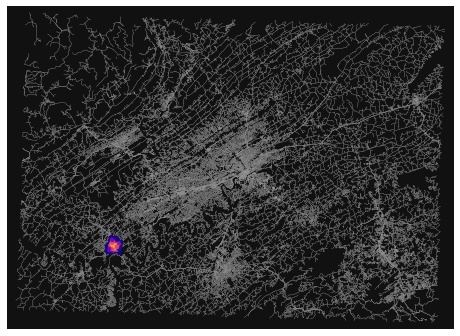

In [11]:
# Get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

# Color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(graph, stores_nearest_nodes[0], radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in graph.nodes()]
ns = [15 if node in node_colors else 0 for node in graph.nodes()]
fig, ax = ox.plot_graph(
    graph,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [25]:
subgraph = nx.ego_graph(graph, center_node, radius=trip_times[0], distance="time")

points = pd.DataFrame([(data['x'], data['y']) for _, data in subgraph.nodes(data=True)], columns=['x', 'y'])
point_geoms = gpd.GeoSeries(points.apply(geometry.Point, axis='columns'))
point_geoms.crs='epsg:32617'

bounding_poly = alphashape.alphashape(point_geoms)
point_geoms.head()

0    POINT (205899.206 3966630.295)
1    POINT (205815.087 3966699.448)
2    POINT (205782.765 3966737.406)
3    POINT (205711.818 3966815.609)
4    POINT (205941.958 3966510.284)
dtype: geometry

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [16]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(graph, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

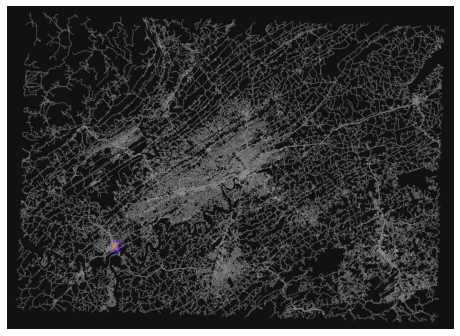

In [17]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(
    graph, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

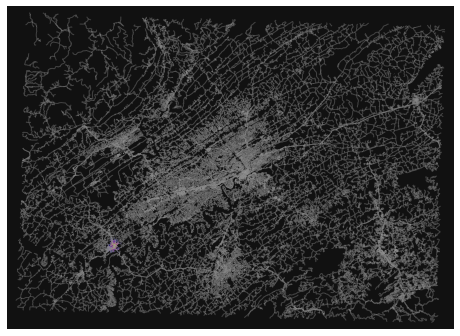

In [18]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(graph, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = graph.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


isochrone_polys = make_iso_polys(graph, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(
    graph, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [ ]:
# https://pythoncharmers.com/blog/travel-distance-python-with-geopandas-folium-alphashape-osmnx-buffer.html